In [1]:
import pandas as pd
import numpy as np

#데이터 로드 함수를 정의합니다. 필요한 레이블을 추출하는 1차 전처리 단계를 거칩니다.
def load_data(path='features_3_sec.csv'):
    #데이터 읽기
    data = pd.read_csv(path)
    
    #인풋 데이터 추출
    data_input = data.drop(columns=['filename', 'length', 'label']).to_numpy()
    #타깃 데이터 추출
    data_target = data['label'].to_numpy()
    
    #반환
    return data_input, data_target

In [2]:
#Load Data
data_input, data_target = load_data('./Data/features_3_sec.csv')

#정규화
#from sklearn.preprocessing import MinMaxScaler
#scaler=MinMaxScaler()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(data_input)
data_input=scaler.transform(data_input)
    
#Split Data
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, test_size=0.2, random_state=42)

#F-fold 교차 검증 분할기
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [3]:

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def rateModel(model):
    model.fit(train_input, train_target)
    TrainScore = model.score(train_input, train_target)
    TestScore = model.score(test_input, test_target)
    KFoldScore = np.mean(cross_val_score(model, data_input, data_target, cv=skf))

    print("Train Score:%.2f"%TrainScore)
    print("Test Score:%.2f"%TestScore)
    print("K-fold Score:%.2f"%KFoldScore)

    pred = cross_val_predict(model, test_input, test_target, cv=skf)
    conf_mx = confusion_matrix(test_target, pred)
    plt.matshow(conf_mx, cmap=plt.cm.Greens)
    plt.colorbar(fraction=0.05, pad=0.05)
    plt.show()

Train Score:1.00
Test Score:0.91
K-fold Score:0.90


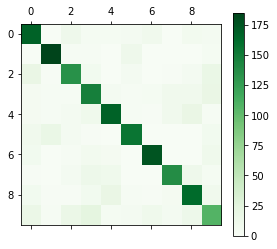

In [5]:
##SVC 모델
from sklearn.svm import SVC
svc = SVC(max_iter=7000, kernel='poly', degree=3, coef0=1, C=5)
rateModel(svc)


Train Score:0.94
Test Score:0.90
K-fold Score:0.88


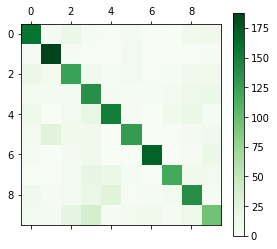

In [79]:
##KNN 모델
from sklearn.neighbors import KNeighborsClassifier
kc = KNeighborsClassifier()
rateModel(kc)

Train Score:0.86
Test Score:0.64
K-fold Score:0.64


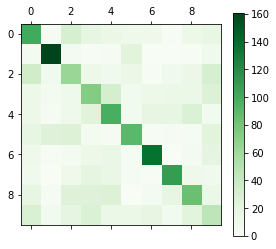

In [80]:
##결정 트리 모델
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(min_samples_leaf=5)
rateModel(dtc)

Train Score:1.00
Test Score:0.89
K-fold Score:0.87


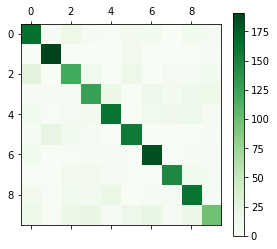

In [81]:
##랜덤 포레스트 모델
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200)
rateModel(rfc)

Train Score:1.00
Test Score:0.90
K-fold Score:0.90


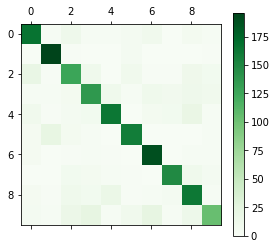

In [82]:
##엑스트라 트리 모델
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators = 200)
rateModel(etc)

Train Score:0.73
Test Score:0.73
K-fold Score:0.71


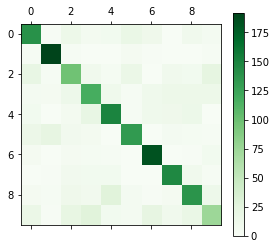

In [10]:
##로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver='liblinear')
rateModel(lg)

Train Score:0.93
Test Score:0.80
K-fold Score:0.79


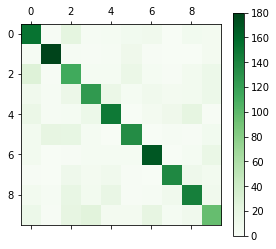

In [91]:
#레이블 인코딩 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

#XSB 분류기
from xgboost import XGBClassifier
xc = XGBClassifier(n_estimators=50, learning_rate=0.05, n_jobs=16)
rateModel(xc)

In [190]:
##그리드 탐색
#트리
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
dtc2 = DecisionTreeClassifier()

param_grid = {
    'min_samples_split':[2,12,22],
    'min_samples_leaf':[1,2,4],
    'max_depth':[None, 5, 8, 11, 13]
}

grid_search = GridSearchCV(dtc2, param_grid, cv=skf)
grid_search.fit(data_input, data_target)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [191]:
##그리드 탐색
#엑스트라 트리
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesClassifier
etc2 = ExtraTreesClassifier(n_estimators = 200)

param_grid = {
    'n_estimators':[50, 100, 200, 400],
    'max_depth':[None, 10, 30, 90, 120, 150],
    'min_samples_split':[2, 4],
    'criterion':['gini', 'entropy'],
}

grid_search = GridSearchCV(etc2, param_grid, cv=skf)
grid_search.fit(data_input, data_target)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 90, 'min_samples_split': 2, 'n_estimators': 400}


In [192]:
##그리드 탐색
#KNN
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
kc = KNeighborsClassifier()


param_grid = {
    'n_neighbors':[1, 3, 5, 10, 18],
    'weights':['uniform', 'distance'],
    'p':[1, 2, 3],
}

grid_search = GridSearchCV(kc, param_grid, cv=skf)
grid_search.fit(data_input, data_target)
print(grid_search.best_params_)

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [194]:
wow = grid_search.best_estimator_

In [7]:

def importance(model):
    attributes = [
        "chroma_stft_mean","chroma_stft_var",
        "rms_mean","rms_var",
        "spectral centroidt_mean","spectral centroid_var",
        "spectral bandwidth_mean","spectral bandwidth_var",
        "rolloff_mean","rolloff_var",
        "zero crossing rate_mean","zero crossing rate_var",
        "harmony_mean","harmony_var",
        "preceptr_mean","preceptr_var",
        "tempo",
        "mfcc_mean","mfcc_var",
        ]
    for i in range(1,20):
        attributes.append("mfcc%d_mean"%i)
        attributes.append("mfcc%d_var"%i)

    importancePair = np.array(sorted(zip(model.feature_importances_, attributes), reverse=True))

    x = range(len(attributes))
    xlabel = np.ravel(importancePair[:,1])
    values = np.ravel(importancePair[:,0]).astype('float64')

    plt.figure(figsize=(14,10))
    plt.barh(x, values)
    plt.yticks(x, xlabel)
    plt.show()

In [11]:
importance(lg)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [275]:
data_input2, data_target2 = load_data(path='./Data/features_30_sec.csv')
import random
idx = random.randrange(0,len(data_target2))
rand_input = data_input2[idx]
rand_target = data_target2[idx]
print(wow.predict([rand_input]), rand_target)

['disco'] disco


In [6]:
import joblib
joblib.dump(svc, 'svc.pkl')


['svc.pkl']